In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import itertools
import datetime
# postgresql backend
import psycopg2
import streamlit as st


In [3]:
def vector_cross_product_2d(v1, v2):
    """Compute the 2D scalar cross product of two vectors."""
    return v1[0] * v2[1] - v1[1] * v2[0]

def check_intersection(line1, line2):
    """Check if two lines on a circle intersect."""
    p1, p2 = line1
    p3, p4 = line2
    
    # Check if points from line2 lie on opposite sides of line1
    cross1 = vector_cross_product_2d(p2 - p1, p3 - p1)
    cross2 = vector_cross_product_2d(p2 - p1, p4 - p1)
    
    # Check if points from line1 lie on opposite sides of line2
    cross3 = vector_cross_product_2d(p4 - p3, p1 - p3)
    cross4 = vector_cross_product_2d(p4 - p3, p2 - p3)
    
    # If the signs of the cross products are different, the lines intersect
    return (cross1 * cross2 < 0) and (cross3 * cross4 < 0)

In [4]:
class GhostBuster:
    def __init__(self, ghostbuster_type, position="", ID=""):
        self.ghostbuster_type = ghostbuster_type  # Can be 'alien' or 'camper'
        self.position = position  # Initialized as empty
        self.ID = ID  # Initialized as empty

gb = GhostBuster("camper")
gb.__dict__

{'ghostbuster_type': 'camper', 'position': '', 'ID': ''}

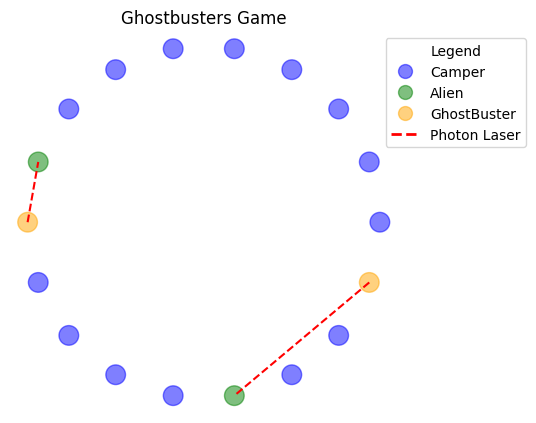

THE WORLD IS SAVED
1 item inserted successfully
{'game_create_time': datetime.datetime(2024, 10, 22, 17, 11, 21, 324469), 'game_num_campers': 18, 'game_num_pairs': 2, 'game_result': 1}


In [11]:
import random
import string
import matplotlib.pyplot as plt
import numpy as np

# GhostBuster class definition
class GhostBuster:
    def __init__(self, ghostbuster_type, position="", ID=""):
        self.ghostbuster_type = ghostbuster_type  # Can be 'camper' or 'alien'
        self.position = position  # Initialized as empty
        self.ID = ID  # Initialized as empty

# gb_game_state class definition (Base class)
class gb_game_state:
    def __init__(self, num_campers, num_pairs, game_type):
        # Check if num_campers is greater than 26
        if num_campers > 26:
            raise ValueError("num_campers must be 26 or less.")
        
        # Check if num_pairs is greater than half of num_campers
        if num_pairs > num_campers // 2:
            raise ValueError("num_pairs must be less than or equal to half of num_campers.")
        
        # Check if num_campers is even
        if num_campers % 2 != 0:
            raise ValueError("num_campers must be an even integer.")
        
        self.num_campers = num_campers  # Even integer
        self.num_pairs = num_pairs
        self.type = game_type  # Either "random" or "manual"
        self.game_ID = self.generate_game_id()  # Random string generated on init
        self.ghostbusters = []  # list containing all ghostbusters instances
        self.campers = []  # list containing all ghostbusters instances with type "camper"
        self.aliens = []  # list containing all ghostbusters instances with type "alien"
        self.game_letters = string.ascii_uppercase[:self.num_campers]
        self.target_dict = {}

    def generate_game_id(self):
        # Generate a random string of 8 characters for the game ID
        return ''.join(random.choices(string.ascii_uppercase + string.digits, k=8))
    
    def create_ghostbusters(self):
        letter_index = 0
        
        # Create one camper and one alien ghostbuster for each pair
        for _ in range(self.num_pairs):
            # Create one camper ghostbuster and assign an ID using letters
            camper_id = self.game_letters[letter_index]
            camper_ghostbuster = GhostBuster('camper', ID=camper_id)
            self.ghostbusters.append(camper_ghostbuster)
            self.campers.append(camper_ghostbuster)
            letter_index += 1

        for _ in range(self.num_pairs):    
            # Create one alien ghostbuster and assign an ID using letters
            alien_id = self.game_letters[letter_index]
            alien_ghostbuster = GhostBuster('alien', ID=alien_id)
            self.ghostbusters.append(alien_ghostbuster)
            self.aliens.append(alien_ghostbuster)
            letter_index += 1
    
    def set_ghostbuster_positions_rand(self):
        # Generate a list of unique random positions
        unique_positions = random.sample(range(self.num_campers), self.num_campers)
        
        # Assign positions to ghostbusters
        for i, ghostbuster in enumerate(self.ghostbusters):
            ghostbuster.position = unique_positions[i]

    def set_targets(self):

        for i in np.arange(0,self.num_pairs):
            self.target_dict[self.campers[i].ID] = self.aliens[i].ID
        
        return self.target_dict

# New gb_game_rep class using composition (holds an instance of gb_game_state)
class gb_game_rep:
    def __init__(self, game_state,verbose = False):
        # Store the game_state instance in the gb_game_rep class
        self.game_state = game_state

        # store verbosity
        self.verbose = verbose
        
        # Additional attribute for the representation of the game
        self.game_representation = {}

        # initialize list to contain line info
        self.line_list = []

        # initialize game result as success
        self.game_result = 'SUCCESS'

    def create_game_rep(self, aliens=[19, 5,6]):
        # Create a DataFrame to hold positions
        df = pd.DataFrame(np.arange(0, self.game_state.num_campers), columns=['POSITION'])
        df['ANGLES'] = np.linspace(0, 2 * np.pi, df.shape[0], endpoint=False)
        df['XPOS'] = 5 * np.cos(df['ANGLES'])
        df['YPOS'] = 5 * np.sin(df['ANGLES'])

        # bring in camper locations from game state
        campers = [c.position for c in self.game_state.campers]
        aliens = [a.position for a in self.game_state.aliens]

        # Initialize camper indicator
        df['CAMPER_IND'] = 0  # Use 0 as the default indicator
        df.loc[campers, 'CAMPER_IND'] = 1  # Set 1 for campers

        # Initialize alien indicator
        df['ALIEN_IND'] = 0  # Use 0 as the default indicator
        df.loc[aliens, 'ALIEN_IND'] = 1  # Set 1 for aliens

        # Assign colors based on indicators
        df['COLOR'] = 'blue'  # Default color
        df.loc[df['ALIEN_IND'] == 1, 'COLOR'] = 'green'  # Set color for aliens
        df.loc[df['CAMPER_IND'] == 1, 'COLOR'] = 'orange'  # Set color for campers

        # Create color list for plotting
        colors = df['COLOR'].tolist()

        # Create the scatter plot
        if self.verbose:
            # Create figure and axis
            fig, ax = plt.subplots(figsize=(5, 5))  # Create figure and axis

            # Plot the scatter plot
            scatter = ax.scatter(df['XPOS'], df['YPOS'], c=colors, s=200, edgecolors=colors, alpha=0.5)

            # Set equal aspect ratio
            ax.set_aspect('equal', adjustable='box')

            # Remove the axes and labels
            ax.set_xticks([])  # Remove x-axis ticks
            ax.set_yticks([])  # Remove y-axis ticks

            # Hide the spines (the borders around the plot)
            ax.spines['top'].set_visible(False)     # Hide top spine
            ax.spines['right'].set_visible(False)   # Hide right spine
            ax.spines['left'].set_visible(False)    # Hide left spine
            ax.spines['bottom'].set_visible(False)  # Hide bottom spine

            # Set the title for the axis
            ax.set_title('Ghostbusters Game')

            # Create a legend based on the colors
            # Assume df['COLORS'] holds categories like 'Campers', 'Aliens', etc., and is mapped to `colors`
            unique_colors = df['COLOR'].unique()  # Get unique categories in df['COLORS']
            legend_handles = []

            legend_dict = {'blue':'Camper','green':'Alien','orange':'GhostBuster'}

            # Create a custom handle for each unique category
            for color in unique_colors:
                # Create a handle with the same color and label
                handle = mlines.Line2D([], [], color=color, 
                                       marker='o', 
                                       linestyle='None', 
                                       markersize=10, 
                                       alpha = 0.5, 
                                       label=legend_dict[color])
                legend_handles.append(handle)

            ax.legend(handles=legend_handles, title='Legend',loc = 'upper right', bbox_to_anchor=(1.3, 1))

            
        
        for p in np.arange(self.game_state.num_pairs):
            p1 = df.loc[campers[p]]
            p2 = df.loc[aliens[p]]

            self.line_list.append((np.array([p1['XPOS'],p1['YPOS']]),np.array([p2['XPOS'],p2['YPOS']])))
            if self.verbose:
                plt.plot([p1['XPOS'], p2['XPOS']], [p1['YPOS'], p2['YPOS']], color='red', linestyle='--')
                

        
        if self.verbose:
            new_line = mlines.Line2D([], [], color='red', linestyle='--', linewidth=2, label='Photon Laser')

            legend_handles.append(new_line)

            # Update the legend with the new handle
            ax.legend(handles=legend_handles, title='Legend', loc='upper right', bbox_to_anchor=(1.35, 1))
            plt.show()
        
        
    
    def check_result(self):
        print(check_intersection(self.line_list[0], self.line_list[1]))
        pass

    def evaluate_game(self):
        int_tests = []
        for pair in itertools.combinations(self.line_list, 2):
            int_tests.append(check_intersection(pair[0], pair[1]))
        if any(element is np.True_ for element in int_tests):
            self.game_result = 0
            if self.verbose:
                print('AT LEAST 2 PROTON BEAMS COLLIDED')
        else:
            self.game_result = 1
            if self.verbose:
                print("THE WORLD IS SAVED")

        self.game_dict = {"game_create_time":datetime.datetime.now(),
             "game_num_campers":self.game_state.num_campers,
             "game_num_pairs":self.game_state.num_pairs,
             "game_result":self.game_result}
        
    def write_game_result(self):
        try:
            connection = psycopg2.connect(user="postgres",
                                        password="postgres",
                                        host="127.0.0.1",
                                        port="5432",
                                        database="postgres")

            cursor = connection.cursor()
            # Executing a SQL query to insert datetime into table
            insert_query = """ INSERT INTO riddler.ghostbusters ("game_create_time",
                    "game_num_campers",
                    "game_num_pairs",
                    "game_result") VALUES (%s, %s, %s, %s)"""
            sql_record = (self.game_dict["game_create_time"],
                self.game_dict["game_num_campers"],
                self.game_dict["game_num_pairs"],
                self.game_dict["game_result"])
            cursor.execute(insert_query, sql_record)
            connection.commit()
            print("1 item inserted successfully")

        except (Exception, psycopg2.Error) as error:
            print("Error while connecting to PostgreSQL", error)
        finally:
            if connection:
                cursor.close()
                connection.close()

        

# Example usage
try:
    # Initialize gb_game_state
    game_state = gb_game_state(18, 2, "random")
    game_state.create_ghostbusters()
    game_state.set_ghostbuster_positions_rand()

    # Initialize gb_game_rep with game_state
    game_rep = gb_game_rep(game_state,verbose=True)

    # Create and display game representation
    game_rep.create_game_rep()
    game_rep.evaluate_game()
    game_rep.write_game_result()
    print(game_rep.game_dict)


    
except ValueError as e:
    print(e)


In [6]:
class game_simulator:
    def __init__(self, num_campers, num_pairs, num_trials):
        """Initialize the simulator with the number of campers, pairs, and trials."""
        self.num_campers = num_campers
        self.num_pairs = num_pairs
        self.num_trials = num_trials
        self.trial_results = []  # List to store the result of each trial
    
    def run_simulation(self):
        """Run the game simulation for the specified number of trials."""
        for trial in range(self.num_trials):
            # print(f"Running trial {trial + 1}...")
            
            # Initialize gb_game_state
            try:
                game_state = gb_game_state(self.num_campers, self.num_pairs, "random")
                game_state.create_ghostbusters()
                game_state.set_ghostbuster_positions_rand()

                # Initialize gb_game_rep with game_state
                game_rep = gb_game_rep(game_state)

                # Create and evaluate the game representation
                game_rep.create_game_rep()
                game_rep.evaluate_game()

                # Record the result of this trial
                self.trial_results.append(game_rep.game_result)

            except ValueError as e:
                print(f"Error in trial {trial + 1}: {e}")
                self.trial_results.append("ERROR")

    def report_results(self):
        """Print a summary of the simulation results, including failure percentage."""
        success_count = self.trial_results.count('SUCCESS')
        fail_count = self.trial_results.count('FAIL')
        error_count = self.trial_results.count('ERROR')

        total_valid_trials = success_count + fail_count  # Exclude errors
        failure_percentage = (fail_count / total_valid_trials) * 100 if total_valid_trials > 0 else 0

        print("\nSimulation Results Summary:")
        print(f"Total Trials: {self.num_trials}")
        print(f"Successful Trials: {success_count}")
        print(f"Failed Trials: {fail_count}")
        print(f"Errors: {error_count}")
        print(f"Failure Percentage: {failure_percentage:.2f}%")


In [11]:
# Create a game simulator with 26 campers, 2 pairs, and 10 trials
simulator = game_simulator(num_campers=20, num_pairs=8, num_trials=10000)

# Run the simulation
simulator.run_simulation()

# Report the results
simulator.report_results()



Simulation Results Summary:
Total Trials: 10000
Successful Trials: 6
Failed Trials: 9994
Errors: 0
Failure Percentage: 99.94%


In [17]:
game_dict = {"game_create_time":datetime.datetime.now(),
             "game_num_campers":20,
             "game_num_pairs":2,
             "game_result":1}

sql_record = (game_dict["game_create_time"],
              game_dict["game_num_campers"],
              game_dict["game_num_pairs"],
              game_dict["game_result"])

sql_record

(datetime.datetime(2024, 10, 15, 14, 41, 10, 721988), 20, 2, 1)

In [19]:
def write_game_result():
    try:
        connection = psycopg2.connect(user="postgres",
                                    password="postgres",
                                    host="127.0.0.1",
                                    port="5432",
                                    database="postgres")

        cursor = connection.cursor()
        # Executing a SQL query to insert datetime into table
        insert_query = """ INSERT INTO riddler.ghostbusters ("game_create_time",
                "game_num_campers",
                "game_num_pairs",
                "game_result") VALUES (%s, %s, %s, %s)"""
        cursor.execute(insert_query, sql_record)
        connection.commit()
        print("1 item inserted successfully")

    except (Exception, psycopg2.Error) as error:
        print("Error while connecting to PostgreSQL", error)
    finally:
        if connection:
            cursor.close()
            connection.close()
            print("PostgreSQL connection is closed")

1 item inserted successfully
PostgreSQL connection is closed


In [ ]:
# analytics
# show probability for 20,2
# show probability for all pairs
# show total games played (last 7 days)
# show 

In [60]:
# Function to fetch query results and return a DataFrame
def fetch_query_as_dataframe(query, connection_params):
    try:
        # Connect to your PostgreSQL database
        conn = psycopg2.connect(**connection_params)
        
        # Create a cursor object
        cursor = conn.cursor()
        
        # Execute the query
        cursor.execute(query)
        
        # Fetch all rows from the executed query
        rows = cursor.fetchall()
        
        # Get column names from the cursor
        colnames = [desc[0] for desc in cursor.description]
        
        # Close the cursor and connection
        cursor.close()
        conn.close()
        
        # Return the results as a pandas DataFrame
        return pd.DataFrame(rows, columns=colnames)
    
    except Exception as e:
        print(f"Error: {e}")
        return None

# Example usage
connection_params = {
    'user':"postgres",
    'password':"postgres",
    'host':"127.0.0.1",
    'port':"5432",
    'database':"postgres"
}

query = """SELECT  game_num_campers,
round(100*sum(CASE WHEN game_result = 0 then 0
ELSE 1
END)/count(*)::numeric,2) AS SUCCESS_RATE_PCT,
count(*) AS COUNT
FROM riddler.ghostbusters
WHERE game_num_campers = 20
AND game_num_pairs = 2
GROUP BY game_num_campers
ORDER BY  game_num_campers;"""

df = fetch_query_as_dataframe(query, connection_params)

print(df)

   game_num_campers success_rate_pct  count
0                20            66.11    900


In [37]:
fail_count = df.loc[df['game_result'] == 0]['count']
success_count = df.loc[df['game_result'] == 1]['count']
fail_rate = int(fail_count.iloc[0])/df['count'].sum()
f"{fail_rate:.2%}"

'33.63%'

In [75]:
import pandas as pd
from sqlalchemy import create_engine

class GBDashData:
    def __init__(self, db_config):
        """
        Initialize the class with a database connection configuration.
        :param db_config: Dictionary containing database connection parameters.
        """
        self.db_config = db_config
        self.engine = self.connect_db()
        self.actual_pct_df = None
        self.success_by_pairs_df = None
        self.success_by_num_campers_df = None
        self.sims_run_df = None

    def connect_db(self):
        """
        Establishes a connection to the PostgreSQL database using SQLAlchemy.
        :return: SQLAlchemy engine object.
        """
        try:
            # Create a PostgreSQL connection string and connect using SQLAlchemy
            db_url = f"postgresql+psycopg2://{self.db_config['user']}:{self.db_config['password']}@{self.db_config['host']}:{self.db_config['port']}/{self.db_config['dbname']}"
            engine = create_engine(db_url)
            return engine
        except Exception as e:
            print(f"Error connecting to database: {e}")
            return None

    def execute_query(self, query):
        """
        Executes the given SQL query and returns the result as a pandas DataFrame.
        :param query: SQL query string.
        :return: DataFrame containing the result of the query.
        """
        if not self.engine:
            print("No database connection available.")
            return pd.DataFrame()

        try:
            # Use pandas' read_sql to run the query using the SQLAlchemy engine
            df = pd.read_sql(query, self.engine)
            return df
        except Exception as e:
            print(f"Error executing query: {e}")
            return pd.DataFrame()

    def actual_pct_query(self):
        """
        Execute the first query and return the result as a pandas DataFrame.
        :return: DataFrame containing the result of the query.
        """
        query = """SELECT  game_num_campers,
                    round(100*sum(CASE WHEN game_result = 0 then 0
                    ELSE 1
                    END)/count(*)::numeric,2) AS SUCCESS_RATE_PCT,
                    count(*) AS COUNT
                    FROM riddler.ghostbusters
                    WHERE game_num_campers = 20
                    AND game_num_pairs = 2
                    GROUP BY game_num_campers
                    ORDER BY  game_num_campers;"""
        return self.execute_query(query)

    def success_by_pairs_query(self):
        """
        Execute the second query and return the result as a pandas DataFrame.
        :return: DataFrame containing the result of the query.
        """
        query = """SELECT  game_num_pairs,
                round(100*sum(CASE WHEN game_result = 0 then 0
                ELSE 1
                END)/count(*)::numeric,2) AS SUCCESS_RATE_PCT,
                count(*) AS COUNT
                FROM riddler.ghostbusters
                GROUP BY game_num_pairs
                ORDER BY  game_num_pairs;"""
        return self.execute_query(query)

    def success_by_num_campers_query(self):
        """
        Execute the third query and return the result as a pandas DataFrame.
        :return: DataFrame containing the result of the query.
        """
        query = """SELECT  game_num_campers,
                    round(100*sum(CASE WHEN game_result = 0 then 0
                    ELSE 1
                    END)/count(*)::numeric,2) AS SUCCESS_RATE_PCT,
                    count(*) AS COUNT
                    FROM riddler.ghostbusters
                    GROUP BY game_num_campers
                    ORDER BY  game_num_campers;"""
        return self.execute_query(query)

    def sims_run_query(self):
        """
        Count how many simulations have been run.
        """
        query = "SELECT COUNT(DISTINCT game_id) AS SIMS_RUN from riddler.ghostbusters;"
        return self.execute_query(query)

    def refresh_data(self):
        """
        Refresh all data by running the queries again and updating DataFrame attributes.
        """
        self.actual_pct_df = self.actual_pct_query()
        self.success_by_pairs_df = self.success_by_pairs_query()
        self.success_by_num_campers_df = self.success_by_num_campers_query()
        self.sims_run_df = self.sims_run_query()

    def close_connection(self):
        """
        Close the SQLAlchemy engine connection.
        """
        if self.engine:
            self.engine.dispose()
            print("Database connection closed.")


In [80]:
db_config = {
    'user':"postgres",
    'password':"postgres",
    'host':"127.0.0.1",
    'port':"5432",
    'database':"postgres",
    'dbname':"postgres"
}

# Initialize the GBDashData class
dashboard_data = GBDashData(db_config)

# Execute queries and get results as DataFrames
dashboard_data.refresh_data()
print(dashboard_data.actual_pct_df)
print(dashboard_data.success_by_pairs_df)
print(dashboard_data.success_by_num_campers_df)
print(dashboard_data.sims_run_df)

   game_num_campers  success_rate_pct  count
0                20             66.11    900
   game_num_pairs  success_rate_pct  count
0               2             67.46   1478
1               3             20.45     44
2               4             10.45    134
3               5              2.82     71
   game_num_campers  success_rate_pct  count
0                 4             53.57     28
1                 6             73.13     67
2                 8             70.18     57
3                10             79.17     72
4                12             66.90    145
5                14             73.08     78
6                16             22.55    204
7                18             67.03     91
8                20             60.98    984
9                26              0.00      1
   sims_run
0      1727


Actual Success Rate: 66.11


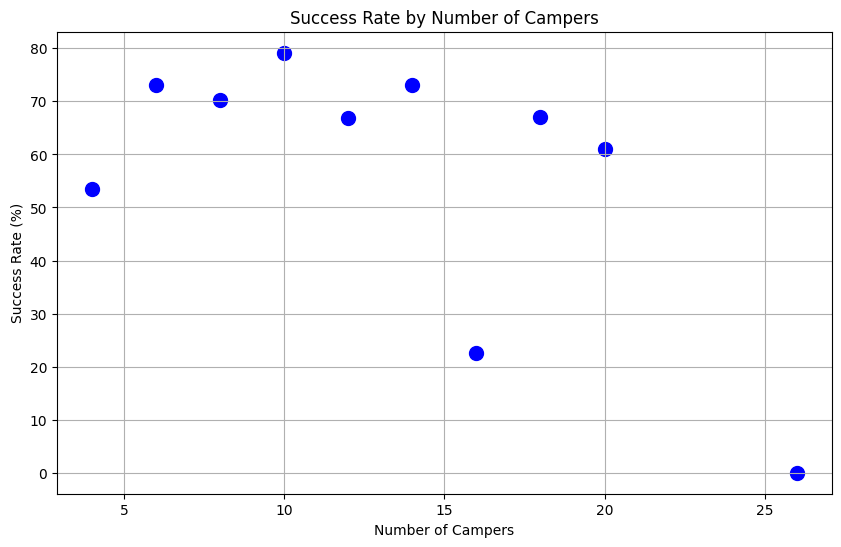

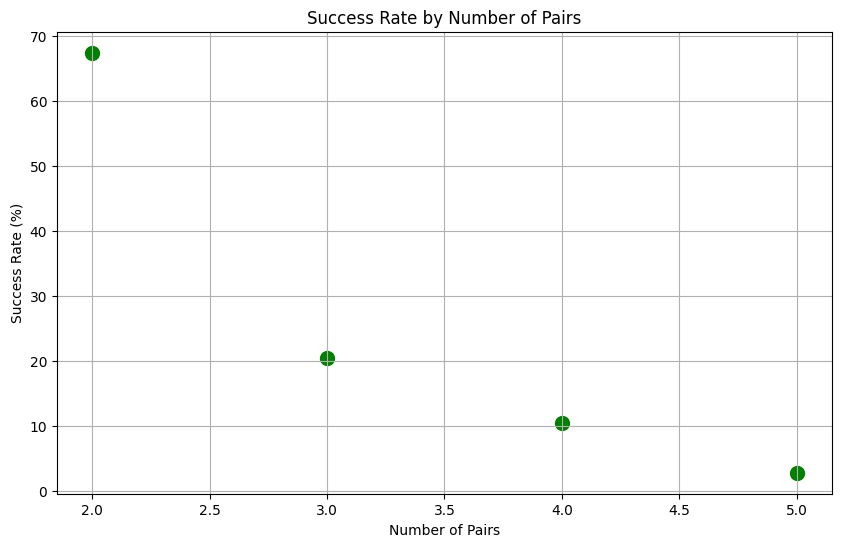

Total simulations run: 1727
Database connection closed.


In [87]:
import matplotlib.pyplot as plt

class GBDashViz:
    def __init__(self, data_instance):
        """
        Initialize GBDashViz with the data from an instance of GBDashData.
        :param data_instance: An instance of GBDashData containing the DataFrames.
        """
        self.actual_pct_df = data_instance.actual_pct_df
        self.success_by_pairs_df = data_instance.success_by_pairs_df
        self.success_by_num_campers_df = data_instance.success_by_num_campers_df
        self.sims_run_df = data_instance.sims_run_df
    
    def plot_actual_pct(self):
        """
        Display the total number of simulations run.
        """
        if self.actual_pct_df is None or self.actual_pct_df.empty:
            print("No data available for the number of simulations.")
            return

        sims_run = self.actual_pct_df.iloc[0]['success_rate_pct']
        print(f"Actual Success Rate: {sims_run}")

    def plot_success_rate_by_campers(self):
        """
        Visualize success rate by the number of campers as a scatter plot.
        """
        if self.success_by_num_campers_df is None or self.success_by_num_campers_df.empty:
            print("No data available for success rate by campers.")
            return
        
        plt.figure(figsize=(10, 6))
        plt.scatter(self.success_by_num_campers_df['game_num_campers'],
                    self.success_by_num_campers_df['success_rate_pct'],
                    c='blue', label='Success Rate', s=100)
        
        plt.title('Success Rate by Number of Campers')
        plt.xlabel('Number of Campers')
        plt.ylabel('Success Rate (%)')
        plt.grid(True)
        plt.show()

    def plot_success_rate_by_pairs(self):
        """
        Visualize success rate by the number of pairs as a scatter plot.
        """
        if self.success_by_pairs_df is None or self.success_by_pairs_df.empty:
            print("No data available for success rate by pairs.")
            return

        plt.figure(figsize=(10, 6))
        plt.scatter(self.success_by_pairs_df['game_num_pairs'],
                    self.success_by_pairs_df['success_rate_pct'],
                    c='green', label='Success Rate', s=100)
        
        plt.title('Success Rate by Number of Pairs')
        plt.xlabel('Number of Pairs')
        plt.ylabel('Success Rate (%)')
        plt.grid(True)
        plt.show()

    def plot_sims_run(self):
        """
        Display the total number of simulations run.
        """
        if self.sims_run_df is None or self.sims_run_df.empty:
            print("No data available for the number of simulations.")
            return

        sims_run = self.sims_run_df.iloc[0]['sims_run']
        print(f"Total simulations run: {sims_run}")

# Example Usage
db_config = {
    'user':"postgres",
    'password':"postgres",
    'host':"127.0.0.1",
    'port':"5432",
    'database':"postgres",
    'dbname':"postgres"
}

# Create an instance of GBDashData and load the data
dashboard_data = GBDashData(db_config)
dashboard_data.refresh_data()

# Create an instance of GBDashViz, passing the GBDashData instance
dashboard_viz = GBDashViz(dashboard_data)

# Call the visualization methods
dashboard_viz.plot_actual_pct()
dashboard_viz.plot_success_rate_by_campers()
dashboard_viz.plot_success_rate_by_pairs()
dashboard_viz.plot_sims_run()

# Close the database connection
dashboard_data.close_connection()


In [71]:
df2.head()

,game_num_pairs,success_rate_pct,count
0,2,67.46,1478
1,3,20.45,44
2,4,10.45,134
3,5,2.82,71


In [6]:
conn = st.connection("postgresql", type="sql")
conn.__class__
# df = conn.query('SELECT * FROM mytable;', ttl="10m")

2024-10-22 16:41:54.203 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-22 16:41:54.205 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-22 16:41:54.205 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-22 16:41:54.208 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-22 16:41:54.208 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


streamlit.connections.sql_connection.SQLConnection

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import itertools
import datetime
# postgresql backend
from sqlalchemy import create_engine
import psycopg2

import streamlit as st

import random
import string


# user defined functions

def vector_cross_product_2d(v1, v2):
    """Compute the 2D scalar cross product of two vectors."""
    return v1[0] * v2[1] - v1[1] * v2[0]

def check_intersection(line1, line2):
    """Check if two lines on a circle intersect."""
    p1, p2 = line1
    p3, p4 = line2
    
    # Check if points from line2 lie on opposite sides of line1
    cross1 = vector_cross_product_2d(p2 - p1, p3 - p1)
    cross2 = vector_cross_product_2d(p2 - p1, p4 - p1)
    
    # Check if points from line1 lie on opposite sides of line2
    cross3 = vector_cross_product_2d(p4 - p3, p1 - p3)
    cross4 = vector_cross_product_2d(p4 - p3, p2 - p3)
    
    # If the signs of the cross products are different, the lines intersect
    return (cross1 * cross2 < 0) and (cross3 * cross4 < 0)


# GhostBuster Class
class GhostBuster:
    def __init__(self, ghostbuster_type, position="", ID=""):
        self.ghostbuster_type = ghostbuster_type  # Can be 'alien' or 'camper'
        self.position = position  # Initialized as empty
        self.ID = ID  # Initialized as empty

# gb_game_state class definition (Base class)
class gb_game_state:
    def __init__(self, num_campers, num_pairs, game_type):
        # Check if num_campers is greater than 26
        if num_campers > 26:
            raise ValueError("num_campers must be 26 or less.")
        
        # Check if num_pairs is greater than half of num_campers
        if num_pairs > num_campers // 2:
            raise ValueError("num_pairs must be less than or equal to half of num_campers.")
        
        # Check if num_campers is even
        if num_campers % 2 != 0:
            raise ValueError("num_campers must be an even integer.")
        
        self.num_campers = num_campers  # Even integer
        self.num_pairs = num_pairs
        self.type = game_type  # Either "random" or "manual"
        self.game_ID = self.generate_game_id()  # Random string generated on init
        self.ghostbusters = []  # list containing all ghostbusters instances
        self.campers = []  # list containing all ghostbusters instances with type "camper"
        self.aliens = []  # list containing all ghostbusters instances with type "alien"
        self.game_letters = string.ascii_uppercase[:self.num_campers]
        self.target_dict = {}

    def generate_game_id(self):
        # Generate a random string of 8 characters for the game ID
        return ''.join(random.choices(string.ascii_uppercase + string.digits, k=8))
    
    def create_ghostbusters(self):
        letter_index = 0
        
        # Create one camper and one alien ghostbuster for each pair
        for _ in range(self.num_pairs):
            # Create one camper ghostbuster and assign an ID using letters
            camper_id = self.game_letters[letter_index]
            camper_ghostbuster = GhostBuster('camper', ID=camper_id)
            self.ghostbusters.append(camper_ghostbuster)
            self.campers.append(camper_ghostbuster)
            letter_index += 1

        for _ in range(self.num_pairs):    
            # Create one alien ghostbuster and assign an ID using letters
            alien_id = self.game_letters[letter_index]
            alien_ghostbuster = GhostBuster('alien', ID=alien_id)
            self.ghostbusters.append(alien_ghostbuster)
            self.aliens.append(alien_ghostbuster)
            letter_index += 1
    
    def set_ghostbuster_positions_rand(self):
        # Generate a list of unique random positions
        unique_positions = random.sample(range(self.num_campers), self.num_campers)
        
        # Assign positions to ghostbusters
        for i, ghostbuster in enumerate(self.ghostbusters):
            ghostbuster.position = unique_positions[i]

    def set_targets(self):

        for i in np.arange(0,self.num_pairs):
            self.target_dict[self.campers[i].ID] = self.aliens[i].ID
        
        return self.target_dict

# gb_game_rep class using composition (holds an instance of gb_game_state)
class gb_game_rep:
    def __init__(self, game_state,verbose = False):
        # Store the game_state instance in the gb_game_rep class
        self.game_state = game_state

        # store verbosity
        self.verbose = verbose
        
        # Additional attribute for the representation of the game
        self.game_representation = {}

        # initialize list to contain line info
        self.line_list = []

        # initialize game result as success
        self.game_result = 'SUCCESS'

    def create_game_rep(self, aliens=[19, 5,6]):
        # Create a DataFrame to hold positions
        df = pd.DataFrame(np.arange(0, self.game_state.num_campers), columns=['POSITION'])
        df['ANGLES'] = np.linspace(0, 2 * np.pi, df.shape[0], endpoint=False)
        df['XPOS'] = 5 * np.cos(df['ANGLES'])
        df['YPOS'] = 5 * np.sin(df['ANGLES'])

        # bring in camper locations from game state
        campers = [c.position for c in self.game_state.campers]
        aliens = [a.position for a in self.game_state.aliens]

        # Initialize camper indicator
        df['CAMPER_IND'] = 0  # Use 0 as the default indicator
        df.loc[campers, 'CAMPER_IND'] = 1  # Set 1 for campers

        # Initialize alien indicator
        df['ALIEN_IND'] = 0  # Use 0 as the default indicator
        df.loc[aliens, 'ALIEN_IND'] = 1  # Set 1 for aliens

        # Assign colors based on indicators
        df['COLOR'] = 'blue'  # Default color
        df.loc[df['ALIEN_IND'] == 1, 'COLOR'] = 'green'  # Set color for aliens
        df.loc[df['CAMPER_IND'] == 1, 'COLOR'] = 'orange'  # Set color for campers

        # Create color list for plotting
        colors = df['COLOR'].tolist()

        # Create the scatter plot
        if self.verbose:
            # Create figure and axis
            fig, ax = plt.subplots(figsize=(5, 5))  # Create figure and axis

            # Plot the scatter plot
            scatter = ax.scatter(df['XPOS'], df['YPOS'], c=colors, s=200, edgecolors=colors, alpha=0.5)

            # Set equal aspect ratio
            ax.set_aspect('equal', adjustable='box')

            # Remove the axes and labels
            ax.set_xticks([])  # Remove x-axis ticks
            ax.set_yticks([])  # Remove y-axis ticks

            # Hide the spines (the borders around the plot)
            ax.spines['top'].set_visible(False)     # Hide top spine
            ax.spines['right'].set_visible(False)   # Hide right spine
            ax.spines['left'].set_visible(False)    # Hide left spine
            ax.spines['bottom'].set_visible(False)  # Hide bottom spine

            # Set the title for the axis
            ax.set_title('Ghostbusters Game')

            # Create a legend based on the colors
            # Assume df['COLORS'] holds categories like 'Campers', 'Aliens', etc., and is mapped to `colors`
            unique_colors = df['COLOR'].unique()  # Get unique categories in df['COLORS']
            legend_handles = []

            legend_dict = {'blue':'Camper','green':'Alien','orange':'GhostBuster'}

            # Create a custom handle for each unique category
            for color in unique_colors:
                # Create a handle with the same color and label
                handle = mlines.Line2D([], [], color=color, 
                                       marker='o', 
                                       linestyle='None', 
                                       markersize=10, 
                                       alpha = 0.5, 
                                       label=legend_dict[color])
                legend_handles.append(handle)

            ax.legend(handles=legend_handles, title='Legend',loc = 'upper right', bbox_to_anchor=(1.3, 1))

            
        
        for p in np.arange(self.game_state.num_pairs):
            p1 = df.loc[campers[p]]
            p2 = df.loc[aliens[p]]

            self.line_list.append((np.array([p1['XPOS'],p1['YPOS']]),np.array([p2['XPOS'],p2['YPOS']])))
            if self.verbose:
                plt.plot([p1['XPOS'], p2['XPOS']], [p1['YPOS'], p2['YPOS']], color='red', linestyle='--')
                

        
        if self.verbose:
            new_line = mlines.Line2D([], [], color='red', linestyle='--', linewidth=2, label='Photon Laser')

            legend_handles.append(new_line)

            # Update the legend with the new handle
            ax.legend(handles=legend_handles, title='Legend', loc='upper right', bbox_to_anchor=(1.35, 1))
            plt.show()
        
        
    
    def check_result(self):
        print(check_intersection(self.line_list[0], self.line_list[1]))
        pass

    def evaluate_game(self):
        int_tests = []
        for pair in itertools.combinations(self.line_list, 2):
            int_tests.append(check_intersection(pair[0], pair[1]))
        if any(element is np.True_ for element in int_tests):
            self.game_result = 0
            if self.verbose:
                print('AT LEAST 2 PROTON BEAMS COLLIDED')
        else:
            self.game_result = 1
            if self.verbose:
                print("THE WORLD IS SAVED")

        self.game_dict = {"game_create_time":datetime.datetime.now(),
             "game_num_campers":self.game_state.num_campers,
             "game_num_pairs":self.game_state.num_pairs,
             "game_result":self.game_result}
        
    def write_game_result(self):
        try:
            connection = psycopg2.connect(user="postgres",
                                        password="postgres",
                                        host="127.0.0.1",
                                        port="5432",
                                        database="postgres")

            cursor = connection.cursor()
            # Executing a SQL query to insert datetime into table
            insert_query = """ INSERT INTO riddler.ghostbusters ("game_create_time",
                    "game_num_campers",
                    "game_num_pairs",
                    "game_result") VALUES (%s, %s, %s, %s)"""
            sql_record = (self.game_dict["game_create_time"],
                self.game_dict["game_num_campers"],
                self.game_dict["game_num_pairs"],
                self.game_dict["game_result"])
            cursor.execute(insert_query, sql_record)
            connection.commit()
            print("1 item inserted successfully")

        except (Exception, psycopg2.Error) as error:
            print("Error while connecting to PostgreSQL", error)
        finally:
            if connection:
                cursor.close()
                connection.close()



class game_simulator:
    def __init__(self, num_campers, num_pairs, num_trials):
        """Initialize the simulator with the number of campers, pairs, and trials."""
        self.num_campers = num_campers
        self.num_pairs = num_pairs
        self.num_trials = num_trials
        self.trial_results = []  # List to store the result of each trial
    
    def run_simulation(self):
        """Run the game simulation for the specified number of trials."""
        for trial in range(self.num_trials):
            # print(f"Running trial {trial + 1}...")
            
            # Initialize gb_game_state
            try:
                game_state = gb_game_state(self.num_campers, self.num_pairs, "random")
                game_state.create_ghostbusters()
                game_state.set_ghostbuster_positions_rand()

                # Initialize gb_game_rep with game_state
                game_rep = gb_game_rep(game_state)

                # Create and evaluate the game representation
                game_rep.create_game_rep()
                game_rep.evaluate_game()

                # Record the result of this trial
                self.trial_results.append(game_rep.game_result)

            except ValueError as e:
                print(f"Error in trial {trial + 1}: {e}")
                self.trial_results.append("ERROR")

    def report_results(self):
        """Print a summary of the simulation results, including failure percentage."""
        success_count = self.trial_results.count('SUCCESS')
        fail_count = self.trial_results.count('FAIL')
        error_count = self.trial_results.count('ERROR')

        total_valid_trials = success_count + fail_count  # Exclude errors
        failure_percentage = (fail_count / total_valid_trials) * 100 if total_valid_trials > 0 else 0

        print("\nSimulation Results Summary:")
        print(f"Total Trials: {self.num_trials}")
        print(f"Successful Trials: {success_count}")
        print(f"Failed Trials: {fail_count}")
        print(f"Errors: {error_count}")
        print(f"Failure Percentage: {failure_percentage:.2f}%")


class GBDashData:
    def __init__(self):
        """
        Initialize the class with a database connection configuration.
        :param db_config: Dictionary containing database connection parameters.
        """
        self.conn = self.connect_db()
        self.actual_pct_df = None
        self.success_by_pairs_df = None
        self.success_by_num_campers_df = None
        self.sims_run_df = None

    def connect_db(self):
        """
        Establishes a connection to the PostgreSQL database using SQLAlchemy.
        :return: SQLAlchemy engine object.
        """
        try:
            # Create a PostgreSQL connection string and connect using SQLAlchemy
            conn = st.connection("postgresql", type="sql")
            return conn
        except Exception as e:
            print(f"Error connecting to database: {e}")
            return None

    def execute_query(self, query):
        """
        Executes the given SQL query and returns the result as a pandas DataFrame.
        :param query: SQL query string.
        :return: DataFrame containing the result of the query.
        """
        if not self.conn:
            print("No database connection available.")
            return pd.DataFrame()

        try:
            # Use streamlit conn.query to query data
            df = self.conn.query(query, ttl="10m")
            return df
        except Exception as e:
            print(f"Error executing query: {e}")
            return pd.DataFrame()

    def actual_pct_query(self):
        """
        Execute the first query and return the result as a pandas DataFrame.
        :return: DataFrame containing the result of the query.
        """
        query = """SELECT  game_num_campers,
                    round(100*sum(CASE WHEN game_result = 0 then 0
                    ELSE 1
                    END)/count(*)::numeric,2) AS SUCCESS_RATE_PCT,
                    count(*) AS COUNT
                    FROM riddler.ghostbusters
                    WHERE game_num_campers = 20
                    AND game_num_pairs = 2
                    GROUP BY game_num_campers
                    ORDER BY  game_num_campers;"""
        return self.execute_query(query)

    def success_by_pairs_query(self):
        """
        Execute the second query and return the result as a pandas DataFrame.
        :return: DataFrame containing the result of the query.
        """
        query = """SELECT  game_num_pairs,
                round(100*sum(CASE WHEN game_result = 0 then 0
                ELSE 1
                END)/count(*)::numeric,2) AS SUCCESS_RATE_PCT,
                count(*) AS COUNT
                FROM riddler.ghostbusters
                GROUP BY game_num_pairs
                ORDER BY  game_num_pairs;"""
        return self.execute_query(query)

    def success_by_num_campers_query(self):
        """
        Execute the third query and return the result as a pandas DataFrame.
        :return: DataFrame containing the result of the query.
        """
        query = """SELECT  game_num_campers,
                    round(100*sum(CASE WHEN game_result = 0 then 0
                    ELSE 1
                    END)/count(*)::numeric,2) AS SUCCESS_RATE_PCT,
                    count(*) AS COUNT
                    FROM riddler.ghostbusters
                    GROUP BY game_num_campers
                    ORDER BY  game_num_campers;"""
        return self.execute_query(query)

    def sims_run_query(self):
        """
        Count how many simulations have been run.
        """
        query = "SELECT COUNT(DISTINCT game_id) AS SIMS_RUN from riddler.ghostbusters;"
        return self.execute_query(query)

    def refresh_data(self):
        """
        Refresh all data by running the queries again and updating DataFrame attributes.
        """
        self.actual_pct_df = self.actual_pct_query()
        self.success_by_pairs_df = self.success_by_pairs_query()
        self.success_by_num_campers_df = self.success_by_num_campers_query()
        self.sims_run_df = self.sims_run_query()

    def close_connection(self):
        """
        Close the streamlit engine connection.
        """
        if self.engine:
            self.engine.dispose()
            print("Database connection closed.")


class GBDashViz:
    def __init__(self, dashboard_data):
        self.data = dashboard_data

    def plot_actual_pct(self):
        df = self.data.actual_pct_df
        actual_success = df['success_rate_pct'].values[0]  # Get the total simulations count

        # Use st.metric to display the number in a more prominent way
        st.metric(label="Actual Success Rate", value=f"{actual_success:,}", delta=None)
        st.metric(label="Target Success Rate", value=66.66, delta=None)

    def plot_success_rate_by_campers(self):
        df = self.data.success_by_num_campers_df
        fig, ax = plt.subplots()
        ax.scatter(df['game_num_campers'], df['success_rate_pct'])
        ax.set_title("Success Rate by Number of Campers")
        ax.set_xlabel("Number of Campers")
        ax.set_ylabel("Success Rate (%)")
        st.pyplot(fig)  # Display the figure in Streamlit

    def plot_success_rate_by_pairs(self):
        df = self.data.success_by_pairs_df
        fig, ax = plt.subplots()
        ax.scatter(df['game_num_pairs'], df['success_rate_pct'])
        ax.set_title("Success Rate by Number of Pairs")
        ax.set_xlabel("Number of Pairs")
        ax.set_ylabel("Success Rate (%)")
        st.pyplot(fig)  # Display the figure in Streamlit

    def plot_sims_run(self):
        df = self.data.sims_run_df
        total_sims = df['sims_run'].values[0]  # Get the total simulations count

        # Use st.metric to display the number in a more prominent way
        st.metric(label="Total Simulations Run", value=f"{total_sims:,}", delta=None)



In [23]:
test = GBDashData()
test.conn


2024-10-22 17:40:45.770 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-22 17:40:45.771 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-22 17:40:45.771 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-22 17:40:45.773 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-10-22 17:40:45.774 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


Error connecting to database: Missing SQL DB connection configuration. Did you forget to set this in `secrets.toml` or as kwargs to `st.connection`?


# Next Steps

- Productionize Code
- Finish Dashboard 1.0 using flask datta able